<a href="https://colab.research.google.com/github/pachterlab/GP_2021_2/blob/main/gg210609_fltseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install mygene
!pip install intervaltree
!pip install gffutils

In [2]:
import numpy as np
import pandas as pd
import mygene
import statsmodels
from statsmodels import discrete
from statsmodels.discrete import discrete_model
import scipy
from scipy import stats
from intervaltree import Interval, IntervalTree
import networkx as nx
import gffutils
import matplotlib.pyplot as plt
from textwrap import wrap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Collect processed data from GitHub.

In [3]:
!curl  -o PromethION_MuSC.zip -L https://github.com/LuyiTian/FLTseq_data/blob/master/data/PromethION_MuSC.zip?raw=true

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   141  100   141    0     0    486      0 --:--:-- --:--:-- --:--:--   486
100   152  100   152    0     0    357      0 --:--:-- --:--:-- --:--:--   357
100 62.4M  100 62.4M    0     0  19.2M      0  0:00:03  0:00:03 --:--:-- 38.6M


In [4]:
%%capture
!unzip PromethION_MuSC.zip

Archive:  PromethION_MuSC.zip
   creating: PromethION_MSC/
   creating: PromethION_MSC/filtered_feature_bc_matrix/
  inflating: PromethION_MSC/filtered_feature_bc_matrix/genes.tsv  
   creating: __MACOSX/
   creating: __MACOSX/PromethION_MSC/
   creating: __MACOSX/PromethION_MSC/filtered_feature_bc_matrix/
  inflating: __MACOSX/PromethION_MSC/filtered_feature_bc_matrix/._genes.tsv  
  inflating: PromethION_MSC/filtered_feature_bc_matrix/barcodes.tsv  
  inflating: __MACOSX/PromethION_MSC/filtered_feature_bc_matrix/._barcodes.tsv  
  inflating: PromethION_MSC/filtered_feature_bc_matrix/matrix.mtx  
  inflating: __MACOSX/PromethION_MSC/filtered_feature_bc_matrix/._matrix.mtx  
  inflating: __MACOSX/PromethION_MSC/._filtered_feature_bc_matrix  
   creating: PromethION_MSC/FLTSA_output/
  inflating: PromethION_MSC/FLTSA_output/fsm_splice_comp.csv  
   creating: __MACOSX/PromethION_MSC/FLTSA_output/
  inflating: __MACOSX/PromethION_MSC/FLTSA_output/._fsm_splice_comp.csv  
  inflating: Prome

In [5]:
!cp PromethION_MSC/FLTSA_output/transcript_count.csv.gz .
!gunzip transcript_count.csv.gz

In [6]:
!cp PromethION_MSC/cluster_annotation.csv .

Identify cells that have been assigned to a cluster. `cluster1` contains quiescent cells, per Fig. S1B.

In [8]:
bc = pd.read_csv('cluster_annotation.csv')

In [9]:
bc_q_filt = bc['groups']=='cluster1'

In [10]:
bc_q = list(bc[bc_q_filt]['barcode_seq'])

In [11]:
bc_a = list(bc[~bc_q_filt]['barcode_seq'])

In [12]:
df = pd.read_csv('transcript_count.csv')

In [13]:
df

,transcript_id,gene_id,AAACGGGCAACGATGG,GAATAAGCATCGATGT,TGAGCCGGTAGGGTAC,TGACTTTCAGCTGGCT,ACTGTCCTCATATCGG,TACGGATTCGTACCGG,TTAGGACGTATAGGTA,GCGACCAGTCGAGTTT,GAACGGAGTCATATCG,GGACAGACACAGCCCA,AGTGTCAAGGCTCATT,TTGAACGTCAACACGT,ACTATCTTCTACCTGC,CGATGTACACCATGTA,CGGACTGCAAGAAGAG,TGCCAAACATCCGCGA,AACTCTTGTCACCTAA,CCAGCGACACGGTAAG,CTCGGGACATCACAAC,CAGCTGGCACTACAGT,GGGCACTCAGCTCCGA,GGCCGATAGGCGCTCT,GTTCGGGGTCTGCAAT,TTGTAGGTCAGTGTTG,CGATGGCTCGGGAGTA,GCTGCTTTCGGTCTAA,GGTGCGTGTTACGTCA,CATCAGACATTGGGCC,CTGTGCTTCCGATATG,ATCTACTAGGAATGGA,ATCATGGGTGACGGTA,TTGTAGGTCGGACAAG,TAGCCGGTCCTGTACC,GACCAATCAGTTCCCT,GCCTCTACAGCTGGCT,ACTGAACGTCGGGTCT,TTTGTCATCACGGTTA,TAGTTGGGTTCAACCA,...,ACTTACTCAGATAATG,ACGCCGACATCACGTA,TAGTTGGAGGACAGCT,GTGTGCGCATTGTGCA,GAATAAGGTAACGTTC,ACTGTCCTCAAGGTAA,GTAGTCAAGTTTGCGT,CCGTACTAGTAGGCCA,CAGCGACCAAGTCATC,GCGACCACATGCAACT,CCAGCGAGTATCACCA,TTAGTTCTCTACCAGA,CTAGAGTTCCAAGCCG,GACTGCGTCATAACCG,GATCTAGAGGACAGAA,GCGAGAAAGAGCTTCT,AGCGGTCGTTATCACG,ACTGAACAGCTGAACG,TCAACGAAGTAGATGT,CTGATCCCACGACTCG,CATGGCGAGGTGTGGT,AGGTCATAGCGTGAAC,AGAATAGAGCCAGTAG,TTGGCAAAGGGTTTCT,AGCGGTCAGGCTCATT,CTCATTATCGAGGTAG,TTCGGTCTCTCGTTTA,TCGCGAGCACAGATTC,ATTATCCGTCAGGACA,TGGTTCCAGGTGTGGT,ATGGGAGCAATGCCAT,AGCGGTCGTTCCAACA,GCAATCACAAACGCGA,GGGCACTTCCTAAGTG,ATCACGAGTCTCTTAT,ATCTACTCAGACAAAT,CAGAGAGAGGGTCTCC,CATATTCCACTAGTAC,CACCTTGAGATATGCA,TCACAAGAGCGTCAAG
0,ENSMUSG00000029270.10_107909202_107987033_1,ENSMUSG00000029270.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000031951.8_111912011_111915338_1,ENSMUSG00000031951.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000021365.15_41311357_41359000_1,ENSMUSG00000021365.15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000058388.14_103991104_104007488_1,ENSMUSG00000058388.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSMUSG00000041236.8_18791585_18866811_1,ENSMUSG00000041236.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,ENSMUSG00000022407.10_80948504_80969119_2,ENSMUSG00000022407.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89170,ENSMUSG00000022407.10_80948504_80969119_5,ENSMUSG00000022407.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89171,ENSMUSG00000022407.10_80948504_80969119_4,ENSMUSG00000022407.10,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,12,0,0,0,1,6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,2,1,0,5,0,0,0,0,0,2,0,0,0,0
89172,ENSMUSG00000034667.8_121611476_121626358_1,ENSMUSG00000034667.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
print(len([k for k in df.columns[2:] if k in bc_a]))
print(len(bc_a))

137
190


In [15]:
print(len([k for k in df.columns[2:] if k in bc_q]))
print(len(bc_q))

51
52


Oddly, there are 1 cell in quiescent and 43 cells in active that do not seem to be represented in the transcript count matrix.

Now let's take the gene IDs and convert them to gene names.

In [16]:
mg = mygene.MyGeneInfo()

Query them using `mygene`...

In [17]:
gene_names = mg.querymany(list(set([k.split('.')[0] for k in df.gene_id])), scopes='ensembl.gene', fields='symbol', species='mouse')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13557...done.
Finished.
99 input query terms found no hit:
	['ENSMUSG00000089525', 'ENSMUSG00000098428', 'ENSMUSG00000098733', 'ENSMUSG00000096391', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [18]:
len(gene_names)

13557

In [19]:
gn = [g for g in gene_names if 'symbol' in g]

In [20]:
len(gn)

13454

103 gene IDs are not in the annotations. We discard them.

In [21]:
gn = {g['query']: g['symbol'] for g in gn}

In [22]:
namecol = [gn.get(g.split('.')[0]) for g in df.gene_id]

In [23]:
df.insert(2,'gene_name',namecol)

In [24]:
filt = [True if namecol[i] is not None else False for i in range(len(namecol))]

We filter out the transcript that correspond to nonexistent gene IDs -- this comes out to 28 rows.

In [25]:
df[filt]

,transcript_id,gene_id,gene_name,AAACGGGCAACGATGG,GAATAAGCATCGATGT,TGAGCCGGTAGGGTAC,TGACTTTCAGCTGGCT,ACTGTCCTCATATCGG,TACGGATTCGTACCGG,TTAGGACGTATAGGTA,GCGACCAGTCGAGTTT,GAACGGAGTCATATCG,GGACAGACACAGCCCA,AGTGTCAAGGCTCATT,TTGAACGTCAACACGT,ACTATCTTCTACCTGC,CGATGTACACCATGTA,CGGACTGCAAGAAGAG,TGCCAAACATCCGCGA,AACTCTTGTCACCTAA,CCAGCGACACGGTAAG,CTCGGGACATCACAAC,CAGCTGGCACTACAGT,GGGCACTCAGCTCCGA,GGCCGATAGGCGCTCT,GTTCGGGGTCTGCAAT,TTGTAGGTCAGTGTTG,CGATGGCTCGGGAGTA,GCTGCTTTCGGTCTAA,GGTGCGTGTTACGTCA,CATCAGACATTGGGCC,CTGTGCTTCCGATATG,ATCTACTAGGAATGGA,ATCATGGGTGACGGTA,TTGTAGGTCGGACAAG,TAGCCGGTCCTGTACC,GACCAATCAGTTCCCT,GCCTCTACAGCTGGCT,ACTGAACGTCGGGTCT,TTTGTCATCACGGTTA,...,ACTTACTCAGATAATG,ACGCCGACATCACGTA,TAGTTGGAGGACAGCT,GTGTGCGCATTGTGCA,GAATAAGGTAACGTTC,ACTGTCCTCAAGGTAA,GTAGTCAAGTTTGCGT,CCGTACTAGTAGGCCA,CAGCGACCAAGTCATC,GCGACCACATGCAACT,CCAGCGAGTATCACCA,TTAGTTCTCTACCAGA,CTAGAGTTCCAAGCCG,GACTGCGTCATAACCG,GATCTAGAGGACAGAA,GCGAGAAAGAGCTTCT,AGCGGTCGTTATCACG,ACTGAACAGCTGAACG,TCAACGAAGTAGATGT,CTGATCCCACGACTCG,CATGGCGAGGTGTGGT,AGGTCATAGCGTGAAC,AGAATAGAGCCAGTAG,TTGGCAAAGGGTTTCT,AGCGGTCAGGCTCATT,CTCATTATCGAGGTAG,TTCGGTCTCTCGTTTA,TCGCGAGCACAGATTC,ATTATCCGTCAGGACA,TGGTTCCAGGTGTGGT,ATGGGAGCAATGCCAT,AGCGGTCGTTCCAACA,GCAATCACAAACGCGA,GGGCACTTCCTAAGTG,ATCACGAGTCTCTTAT,ATCTACTCAGACAAAT,CAGAGAGAGGGTCTCC,CATATTCCACTAGTAC,CACCTTGAGATATGCA,TCACAAGAGCGTCAAG
0,ENSMUSG00000029270.10_107909202_107987033_1,ENSMUSG00000029270.10,Dipk1a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000031951.8_111912011_111915338_1,ENSMUSG00000031951.8,Tmem231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000021365.15_41311357_41359000_1,ENSMUSG00000021365.15,Nedd9,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000058388.14_103991104_104007488_1,ENSMUSG00000058388.14,Phtf1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSMUSG00000041236.8_18791585_18866811_1,ENSMUSG00000041236.8,Vps41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,ENSMUSG00000022407.10_80948504_80969119_2,ENSMUSG00000022407.10,Adsl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89170,ENSMUSG00000022407.10_80948504_80969119_5,ENSMUSG00000022407.10,Adsl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89171,ENSMUSG00000022407.10_80948504_80969119_4,ENSMUSG00000022407.10,Adsl,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,12,0,0,0,1,6,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,2,1,0,5,0,0,0,0,0,2,0,0,0,0
89172,ENSMUSG00000034667.8_121611476_121626358_1,ENSMUSG00000034667.8,Xpot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Construct separate dataframes for active and quescent clusters.

In [26]:
df_a = df.filter(items=['transcript_id','gene_id','gene_name']+bc_a,axis=1)

In [27]:
df_q = df.filter(items=['transcript_id','gene_id','gene_name']+bc_q,axis=1)

Let's look at gene-level data.

In [28]:
df_a_gene = df_a.groupby(['gene_name']).sum()

In [29]:
n_high_exp_genes = 1000

In [30]:
df_a_gene.sum(1).sort_values(ascending=False)[:n_high_exp_genes]

gene_name
Tmsb10     81345
Rplp0      78882
Lgals1     73201
Rps2       71498
Eef1a1     69491
           ...  
Cdk1        1132
Kpna2       1132
Zc3h15      1131
Spc24       1130
Dnajb11     1129
Length: 1000, dtype: int64

In [31]:
high_exp_genes = df_a_gene.sum(1).sort_values(ascending=False)[:n_high_exp_genes].index

In [32]:
filt = [True if df_a_gene.index[i] in high_exp_genes else False for i in range(len(df_a_gene.index))]

In [33]:
df_a_gene = df_a_gene[filt]

In [34]:
df_a_gene

,ATTTCTGCAAGCTGAG,TTGTAGGTCAGTGTTG,TGGCGCAGTACGCACC,TCAGGATTCACCCGAG,ACCGTAACAAGCGTAG,TGGACGCAGAACTGTA,TGGTTCCAGGTGTGGT,TCGTACCTCCTTGCCA,AAGCCGCGTGTGAATA,CCTCAGTCATCGACGC,CAAGAAACATATACCG,GACTAACTCCAAAGTC,GATCGCGCATCCCACT,GAACGGAGTCGCATCG,GGTGCGTAGAACAACT,CAGCTGGGTGCCTGGT,GACACGCGTATCTGCA,GTGTGCGCATTGTGCA,CCTTACGTCACGCATA,TCTCTAACAATGAAAC,CTGTGCTTCCGATATG,GATGAGGAGAACAACT,CGGACTGCAAGAAGAG,ATCCGAATCTGGCGAC,CAAGGCCCAAGCGTAG,CTCGTACGTACTTGAC,GTACGTATCTTCATGT,GAGTCCGCATTGGTAC,CGCCAAGCATCCGCGA,CGTGAGCCACATTCGA,GTAACTGAGATGAGAG,GGATGTTAGGTTACCT,TCGCGAGGTCTAGAGG,CGGACTGAGTTGAGTA,CTAATGGGTCGCATCG,GCACATAAGCAGACTG,CTTGGCTCATTGAGCT,ACTGAACCACAACGCC,TGGACGCAGAAGATTC,GTCGTAATCCTTGCCA,...,CGATGTACACCATGTA,TCTGGAAGTATAGGGC,ACAGCCGTCTTGAGAC,AGCGGTCGTTCCAACA,CCGTACTCAATCGGTT,CCGTACTAGTAGGCCA,CGGACACGTCTCAACA,ACGTCAAGTATGCTTG,TCAGGATAGTACCGGA,TGATTTCCACGGTAAG,GGACAGACACAGCCCA,CCAATCCAGTCATGCT,ATCATCTTCCGTAGGC,CACCACTCAGTAGAGC,CACCTTGTCTGCAGTA,AGCGGTCGTTATCACG,ACACCGGAGGAGTACC,AGCGTATTCTATCCTA,GCGAGAAAGAGCTTCT,GACGTGCTCGTCGTTC,TTATGCTCACGTCAGC,TCAGGATAGAAGGTTT,TGATTTCAGATGTGTA,GGGTTGCAGATGCCAG,AGAATAGAGGAGTACC,GGGCACTTCTGTTGAG,TTAGGACGTATAGGTA,CGGAGTCCACAGGAGT,CTGATCCCAGATTGCT,CTCGGGACATCACAAC,TCTATTGGTGATGATA,TCACAAGAGTTTAGGA,CAGCATAAGACGACGT,CATCGAACACATGACT,CGTCTACAGAGTGAGA,TGCCCTACACCCAGTG,TAGTTGGGTTCAACCA,TAGGCATGTCTCCATC,ACTGATGTCCAACCAA,GTAGGCCTCTCGCATC
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1110004F10Rik,13,44,17,63,14,17,24,4,16,29,54,27,20,18,11,3,9,29,6,16,18,49,18,10,10,19,38,29,7,17,25,19,35,14,10,2,21,7,16,1,...,0,2,0,3,0,7,0,1,1,0,0,0,0,2,9,4,1,0,3,1,0,0,1,0,0,1,0,5,0,0,2,0,0,1,0,0,2,0,0,0
1110038B12Rik,57,14,37,45,26,19,33,38,69,52,21,23,37,46,18,7,53,25,68,54,26,22,58,16,14,19,14,12,13,9,25,14,24,35,13,34,12,15,50,16,...,0,5,0,6,1,8,4,0,1,1,2,0,0,1,14,5,1,0,0,0,1,3,2,0,1,1,0,13,2,0,0,0,2,1,0,2,1,0,0,2
2410006H16Rik,40,22,18,63,13,33,16,79,30,33,12,20,39,41,11,13,43,22,73,46,21,22,60,45,22,22,33,10,10,14,24,9,23,92,23,31,29,67,33,24,...,4,3,0,7,0,4,0,0,1,1,0,0,0,3,11,10,0,1,0,1,1,2,2,0,0,0,1,3,0,1,0,0,0,0,1,0,2,2,0,0
AI506816,18,17,33,58,7,26,37,16,27,28,40,35,28,7,23,35,12,5,20,26,46,26,22,33,16,17,69,26,14,43,35,59,12,32,34,24,31,4,22,8,...,0,1,8,4,0,2,0,6,4,2,0,1,0,1,17,8,2,0,0,0,0,3,0,1,2,1,0,2,0,0,3,1,5,1,1,1,2,0,1,0
Aamp,10,19,30,48,13,32,21,18,22,8,30,36,8,20,5,0,6,18,21,18,20,21,7,6,34,12,10,7,24,9,1,12,16,14,22,29,5,30,22,39,...,1,6,0,0,0,1,4,1,0,1,5,0,0,2,13,5,1,1,1,0,1,1,1,1,1,1,0,8,0,0,1,0,1,0,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhaz,20,41,10,37,6,32,11,16,23,34,17,16,20,25,18,20,12,4,16,33,10,21,19,44,12,9,18,4,15,14,5,12,13,15,18,15,10,7,16,7,...,2,6,5,23,0,1,11,0,0,2,7,1,0,2,10,34,5,0,0,0,1,1,2,0,1,3,0,44,0,1,0,1,1,2,0,0,12,1,0,0
Zc3h15,16,24,11,23,33,15,28,26,28,20,18,16,7,18,17,5,19,36,7,24,10,22,19,21,13,8,36,5,30,8,16,10,22,27,42,9,11,33,10,5,...,3,1,0,2,0,8,0,1,1,0,4,0,0,5,6,6,0,0,0,0,0,0,2,1,0,0,2,2,0,0,2,1,0,1,2,1,2,1,0,0
Zfas1,36,48,32,52,42,50,47,36,52,21,25,27,40,33,13,13,62,26,105,68,17,43,26,32,37,16,21,15,26,11,15,3,28,60,23,12,35,68,43,36,...,0,3,0,4,1,6,1,0,1,1,0,1,0,0,13,4,1,0,0,0,0,1,1,4,0,0,0,2,2,0,2,1,2,2,0,0,4,0,1,0


Let's look at submolecular details now.

In [35]:
!gunzip PromethION_MSC/FLTSA_output/tr_coverage.csv.gz
!gunzip PromethION_MSC/FLTSA_output/transcript_assembly_classification.txt.gz
!gunzip PromethION_MSC/FLTSA_output/transcript_assembly_junctions.txt.gz

In [36]:
!head -10 PromethION_MSC/FLTSA_output/transcript_assembly_junctions.txt

isoform	chrom	strand	junction_number	genomic_start_coord	genomic_end_coord	transcript_coord	junction_category	start_site_category	end_site_category	diff_to_Ref_start_site	diff_to_Ref_end_site	bite_junction	splice_site	canonical	RTS_junction	indel_near_junct	phyloP_start	phyloP_end	sample_with_cov	total_coverage
ENSMUSG00000056673.14_897788_900934_1	chrY	+	junction_1	898116	899427	?????	novel	known	known	0	0	TRUE	GTAG	canonical	FALSE	FALSE	NA	NA	NA	NA
ENSMUSG00000056673.14_897788_900934_1	chrY	+	junction_2	899551	899786	?????	known	known	known	0	0	TRUE	GTAG	canonical	FALSE	FALSE	NA	NA	NA	NA
ENSMUSG00000056673.14_897788_900934_1	chrY	+	junction_3	899958	900478	?????	known	known	known	0	0	TRUE	GTAG	canonical	FALSE	FALSE	NA	NA	NA	NA
ENSMUST00000189069.6	chrY	+	junction_1	898116	898549	?????	known	known	known	0	0	TRUE	GTAG	canonical	FALSE	FALSE	NA	NA	NA	NA
ENSMUST00000189069.6	chrY	+	junction_2	898628	899427	?????	known	known	known	0	0	TRUE	GTAG	canonical	FALSE	FALSE	NA	NA	NA	NA
ENSMUST0000

In [37]:
df_a

,transcript_id,gene_id,gene_name,ATTTCTGCAAGCTGAG,TTGTAGGTCAGTGTTG,TGGCGCAGTACGCACC,TCAGGATTCACCCGAG,ACCGTAACAAGCGTAG,TGGACGCAGAACTGTA,TGGTTCCAGGTGTGGT,TCGTACCTCCTTGCCA,AAGCCGCGTGTGAATA,CCTCAGTCATCGACGC,CAAGAAACATATACCG,GACTAACTCCAAAGTC,GATCGCGCATCCCACT,GAACGGAGTCGCATCG,GGTGCGTAGAACAACT,CAGCTGGGTGCCTGGT,GACACGCGTATCTGCA,GTGTGCGCATTGTGCA,CCTTACGTCACGCATA,TCTCTAACAATGAAAC,CTGTGCTTCCGATATG,GATGAGGAGAACAACT,CGGACTGCAAGAAGAG,ATCCGAATCTGGCGAC,CAAGGCCCAAGCGTAG,CTCGTACGTACTTGAC,GTACGTATCTTCATGT,GAGTCCGCATTGGTAC,CGCCAAGCATCCGCGA,CGTGAGCCACATTCGA,GTAACTGAGATGAGAG,GGATGTTAGGTTACCT,TCGCGAGGTCTAGAGG,CGGACTGAGTTGAGTA,CTAATGGGTCGCATCG,GCACATAAGCAGACTG,CTTGGCTCATTGAGCT,...,CGATGTACACCATGTA,TCTGGAAGTATAGGGC,ACAGCCGTCTTGAGAC,AGCGGTCGTTCCAACA,CCGTACTCAATCGGTT,CCGTACTAGTAGGCCA,CGGACACGTCTCAACA,ACGTCAAGTATGCTTG,TCAGGATAGTACCGGA,TGATTTCCACGGTAAG,GGACAGACACAGCCCA,CCAATCCAGTCATGCT,ATCATCTTCCGTAGGC,CACCACTCAGTAGAGC,CACCTTGTCTGCAGTA,AGCGGTCGTTATCACG,ACACCGGAGGAGTACC,AGCGTATTCTATCCTA,GCGAGAAAGAGCTTCT,GACGTGCTCGTCGTTC,TTATGCTCACGTCAGC,TCAGGATAGAAGGTTT,TGATTTCAGATGTGTA,GGGTTGCAGATGCCAG,AGAATAGAGGAGTACC,GGGCACTTCTGTTGAG,TTAGGACGTATAGGTA,CGGAGTCCACAGGAGT,CTGATCCCAGATTGCT,CTCGGGACATCACAAC,TCTATTGGTGATGATA,TCACAAGAGTTTAGGA,CAGCATAAGACGACGT,CATCGAACACATGACT,CGTCTACAGAGTGAGA,TGCCCTACACCCAGTG,TAGTTGGGTTCAACCA,TAGGCATGTCTCCATC,ACTGATGTCCAACCAA,GTAGGCCTCTCGCATC
0,ENSMUSG00000029270.10_107909202_107987033_1,ENSMUSG00000029270.10,Dipk1a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000031951.8_111912011_111915338_1,ENSMUSG00000031951.8,Tmem231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000021365.15_41311357_41359000_1,ENSMUSG00000021365.15,Nedd9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000058388.14_103991104_104007488_1,ENSMUSG00000058388.14,Phtf1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSMUSG00000041236.8_18791585_18866811_1,ENSMUSG00000041236.8,Vps41,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,ENSMUSG00000022407.10_80948504_80969119_2,ENSMUSG00000022407.10,Adsl,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89170,ENSMUSG00000022407.10_80948504_80969119_5,ENSMUSG00000022407.10,Adsl,0,0,4,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89171,ENSMUSG00000022407.10_80948504_80969119_4,ENSMUSG00000022407.10,Adsl,0,12,17,19,0,4,5,2,0,0,36,7,0,0,3,0,0,0,0,0,6,10,0,0,0,0,11,0,4,3,0,0,6,0,6,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
89172,ENSMUSG00000034667.8_121611476_121626358_1,ENSMUSG00000034667.8,Xpot,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
!head -10 PromethION_MSC/FLTSA_output/isoform_annotated.filtered.gff3

##gff-version 3
chr7	FLTSA	gene	3289179	3313348	.	+	.	ID=gene:ENSMUSG00000068566.12;gene_id=ENSMUSG00000068566.12;support_count=824
chr7	FLTSA	transcript	3290705	3302995	.	+	.	ID=transcript:ENSMUSG00000068566.12_3290705_3302995_1;transcript_id=ENSMUSG00000068566.12_3290705_3302995_1;Parent=gene:ENSMUSG00000068566.12;support_count=12
chr7	FLTSA	exon	3290705	3290792	.	+	.	exon_id=exon:3290705_3290792;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=1
chr7	FLTSA	exon	3293203	3293291	.	+	.	exon_id=exon:3293203_3293291;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=2
chr7	FLTSA	exon	3296722	3297749	.	+	.	exon_id=exon:3296722_3297749;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=3
chr7	FLTSA	exon	3301641	3302995	.	+	.	exon_id=exon:3301641_3302995;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=4
chr7	FLTSA	transcript	3290575	3299137	.	+	.	ID=transcript:ENSMUSG00000068566.12_3290575_3299137_1;transcript_id=ENSMUSG00000068566.12_329

Build a database for `gff` query. Warning: this might take a few minutes.

In [39]:
gff_file = './PromethION_MSC/FLTSA_output/isoform_annotated.filtered.gff3'
db = gffutils.create_db(gff_file,dbfn='dfbn.db')

In [40]:
db = gffutils.FeatureDB('dfbn.db')
features = db.all_features()


In [41]:
def compile_exons(gene_df,db,plot=True):
    i=1
    x = []
    for tid in gene_df['transcript_id']:
        pr = list(db.parents('transcript:'+tid))
        exons = list(db.children('transcript:'+tid,featuretype='exon'))
        if len(pr)==1:
            gene_begin = pr[0][3]
            gene_end = pr[0][4]
            gene_length = gene_end-gene_begin
        else:
            print('No unique transcript identified!')
        exons = [[exon[3]-gene_begin, exon[4]-gene_begin] for exon in exons]

        x.append(exons)
        if plot:
            for exon in exons:
                plt.plot(exon,[i,i])
        i+=1
    return x

def construct_transcript_interval_map(exons,plot=True):   
    i=0

    t = IntervalTree(IntervalTree.from_tuples([it for sl in exons for it in sl]))
    t.split_overlaps()
    intervals = [list(t_)[:2] for t_ in t]

    transcript_interval_map = []
    cm = plt.cm.get_cmap('tab20',len(intervals))
    for tr in exons:
        exlist = [False]*len(intervals)
        for ex in tr:
            exon_int = [list(t_)[:2] for t_ in t[ex[0]:ex[1]]]
            exlist = [a or b for a,b in zip(exlist,[True if interval in exon_int else False for interval in intervals])] #not very efficient
        for j in range(len(intervals)):
            if exlist[j] and plot:
                plt.plot(intervals[j],[i,i],color=cm(j))
        transcript_interval_map.append(exlist)
        i+=1

    if plot:
        plt.gca().invert_yaxis()
    return transcript_interval_map
 
def construct_dag(transcript_interval_map,append_nas_root=False):
    if append_nas_root:
        transcript_interval_map = [[True]*len(intervals)] + transcript_interval_map
    ex_arr = np.array(transcript_interval_map,dtype=int)
    niso = len(ex_arr)
    dist = np.zeros((niso,niso))
    for i in range(niso):
        for j in range(niso):
            if np.all((ex_arr[i]-ex_arr[j])>=0):
                dist[i,j] = sum(ex_arr[i]-ex_arr[j])
            else: 
                dist[i,j] = np.inf

    reachability = np.copy(dist)
    reachability = np.logical_and(np.isfinite(reachability), reachability>0)
    G = build_dag(niso,reachability)
    return G

def build_dag(nodes,reachability):
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    for i in range(nodes):
        for j in range(nodes):
            if reachability[i,j]:
                G.add_edge(i,j)
    H = nx.algorithms.dag.transitive_reduction(G)
    return H

In [42]:
%%capture
CORR_TRUE = []
CORR_THEO = []
rej_badfit = 0
rej_underdisp = 0
rej_construction = 0
n_transc = 0
genes_rej = 0

rej_badfit_mean = []
for gene_ind in range(1000): 
    df_gene = df_a[df_a['gene_name']==high_exp_genes[gene_ind]]
    exons = compile_exons(df_gene,db,plot=False)
    try:
        transcript_interval_map = construct_transcript_interval_map(exons,plot=False)
    except:
        genes_rej += 1
        rej_construction+= len(df_gene)
        continue
    G=construct_dag(transcript_interval_map)
    roots = [i for i in G.nodes() if G.in_degree(i)==0 ]
    data_X = np.asarray([df_gene.iloc[i,3:] for i in roots],dtype=float)
    filt = np.mean(data_X,axis=1)<np.var(data_X,axis=1)
    rej_underdisp += np.sum((~filt).astype(int))
    data_X = data_X[filt]

    nr = len(data_X)

    PARAMS = np.zeros((nr,2))
    filt = np.ones(nr,dtype=bool)
    for i in range(nr):
        model = statsmodels.discrete.discrete_model.NegativeBinomial(data_X[i],np.ones_like(data_X[i]))
        fit = model.fit(disp=0)
        if not fit.mle_retvals['converged']:
            print("not converged!")
            filt[i] = 0
        params = fit.params
        g = params[1]
        b = np.exp(params[0])*g
        PARAMS[i,:] = [b,g]
    filt = filt & np.all(PARAMS>1e-5,axis=1)
    rej_badfit +=  np.sum((~filt).astype(int))
    rej_badfit_mean.append(np.mean(data_X[~filt],axis=1))
    nr = np.sum(filt.astype(int))
    PARAMS = PARAMS[filt]
    data_X = data_X[filt]


    CORR = np.zeros((nr,nr))
    for i in range(nr):
        for j in range(i,nr):
            g1 = PARAMS[i,1]
            g2 = PARAMS[j,1]
            b1 = PARAMS[i,0]
            b2 = PARAMS[j,0]
            CORR[i,j] = 2*np.sqrt(g1*g2)/(g1+g2)*np.sqrt(1/((1+1/b1)*(1+1/b2)))
            if i==j:
                CORR[i,j]=1
    n_transc += nr

    corr_true = np.corrcoef(data_X)
    triu = np.triu_indices(nr,k=1)

    if nr>1:
        CORR_TRUE.append(corr_true[triu][:])
        CORR_THEO.append(CORR[triu][:])



In [43]:
CORR_THEO = np.asarray([item for sublist in CORR_THEO for item in sublist],dtype=float)
CORR_TRUE = np.asarray([item for sublist in CORR_TRUE for item in sublist],dtype=float)

In [44]:
rej_badfit_mean = np.asarray([item for sublist in rej_badfit_mean for item in sublist],dtype=float)

In [45]:
np.sum(rej_badfit_mean>1)

1

Text(0, 0.5, 'number of transcripts')

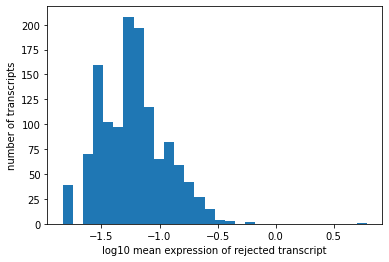

In [46]:
plt.hist(np.log10(rej_badfit_mean),30)
plt.xlabel('log10 mean expression of rejected transcript')
plt.ylabel('number of transcripts')

In [47]:
genes_rej

1

In [48]:
n_transc

4363

In [49]:
rej_badfit 

1289

In [50]:
rej_underdisp

732

In [51]:
rej_construction 

11

In [52]:
np.sum(CORR_THEO > CORR_TRUE)

11884

In [53]:
len(CORR_THEO)

12470

In [54]:
np.sum(CORR_THEO < CORR_TRUE)

586

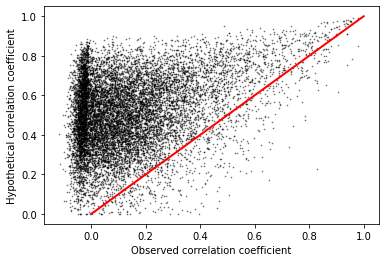

In [55]:
plt.plot(CORR_TRUE,CORR_THEO,'k.',alpha=0.5,markersize=1.3)
plt.plot([0,1],[0,1],'r-',linewidth=2)
plt.box('off')
plt.xlabel("Observed correlation coefficient")
plt.ylabel("Hypothetical correlation coefficient")
plt.savefig('corrcoef.png',dpi=600)

Let's see what the exon graphs look like.

In [80]:
df_gene = df_a[df_a['gene_name']=='Rps13']
data_X = np.asarray([df_gene.iloc[i,3:] for i in roots],dtype=float)



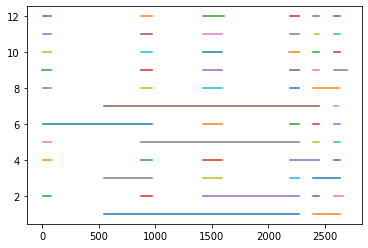

In [81]:

exons = compile_exons(df_gene,db,plot=True)



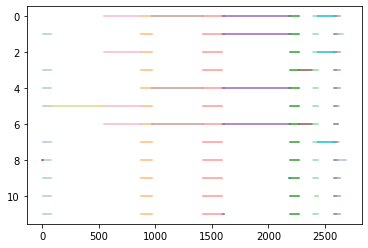

In [82]:
transcript_interval_map = construct_transcript_interval_map(exons,plot=True)

This transcript interval map implies a reachability DAG (or equivalent transitive reduction), with the "root" transcripts marked in red.

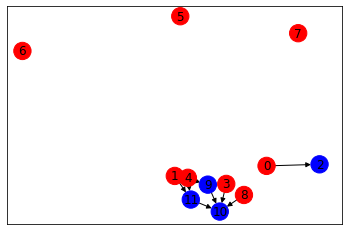

In [83]:
G=construct_dag(transcript_interval_map)
roots = [i for i in G.nodes() if G.in_degree(i)==0]
colors = ['r' if i in roots else 'b' for i in  G.nodes()  ]
nx.draw_networkx(G,node_color=colors)

In [56]:
!pip list

Package                       Version            
----------------------------- -------------------
absl-py                       0.12.0             
alabaster                     0.7.12             
albumentations                0.1.12             
altair                        4.1.0              
appdirs                       1.4.4              
argcomplete                   1.12.3             
argh                          0.26.2             
argon2-cffi                   20.1.0             
arviz                         0.11.2             
astor                         0.8.1              
astropy                       4.2.1              
astunparse                    1.6.3              
async-generator               1.10               
atari-py                      0.2.9              
atomicwrites                  1.4.0              
attrs                         21.2.0             
audioread                     2.1.9              
autograd                      1.3                
